In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import pingouin as pg
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups = pd.read_csv('groups.csv', sep=';')

# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
group_add = pd.read_csv('group_add.csv')

# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs = pd.read_csv('active_studs.csv')

# файл с информацией об оплатах пользователей в дни проведения эксперимента. 
checks = pd.read_csv('checks.csv', sep=';')

In [3]:
# переименуем столбцы id в данных у groups и group_add в student_id, для облегчения работы в дальнейшнем
groups = groups.rename(columns={'id': 'student_id'})
group_add = group_add.rename(columns={'id': 'student_id'})

In [4]:
# соединим два датасета с принадлежностью с экспериментом
# предварительно проверим есть ли в двух файлах одинаковые пользователи
groups.merge(group_add, on='student_id', how='inner')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,student_id,grp_x,grp_y


In [5]:
# одинаковых нет, сначит можем соединить в один файл
groups_df = pd.concat([groups, group_add])

In [6]:
# Проверим какой части пользователей показалась страница оплаты
active_studs.merge(groups_df, on='student_id', how='inner').count()

student_id    8341
grp           8341
dtype: int64

In [7]:
# проверим сколько было оплат из активных пользователей
active_studs.merge(checks, on='student_id', how='inner').count()

student_id    392
rev           392
dtype: int64

In [8]:
# проверим сколько было оплат из пользователей с расставленной группой эксперимента
groups_df.merge(checks, on='student_id', how='inner').count()

student_id    541
grp           541
rev           541
dtype: int64

In [9]:
# получается, что не все пользотели зашли на сайт
# но при этом часть пользователей оплачивали не заходя на сайт (либо долетели старые оплаты)
# сделаем датасет только с активными пользователями и добавим оплаты
active = groups_df.merge(active_studs, on='student_id', how='inner') \
                  .merge(checks, on='student_id', how = 'left') \
                  .fillna(0)

In [10]:
# также добавим факт Покупки
active['purch'] = active.rev.apply(lambda x: 1 if x > 0 else 0)
active.head()

,student_id,grp,rev,purch
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


In [37]:
# Зададим датасеты для пользователей с покупками
active_purch_a = active.query('grp == "A" & rev > 0')
active_purch_b = active.query('grp == "B" & rev > 0')
active_purch = active.query('rev > 0')

In [12]:
active_purch

,student_id,grp,rev,purch
0,1627,A,990.0000,1
10,100300,B,990.0000,1
12,108270,B,290.0000,1
246,264473,B,1900.0001,1
279,274352,B,690.0000,1
...,...,...,...,...
8312,5645737,B,1900.0000,1
8314,5651566,B,1900.0000,1
8316,5662322,B,1900.0000,1
8323,5681918,B,1900.0000,1


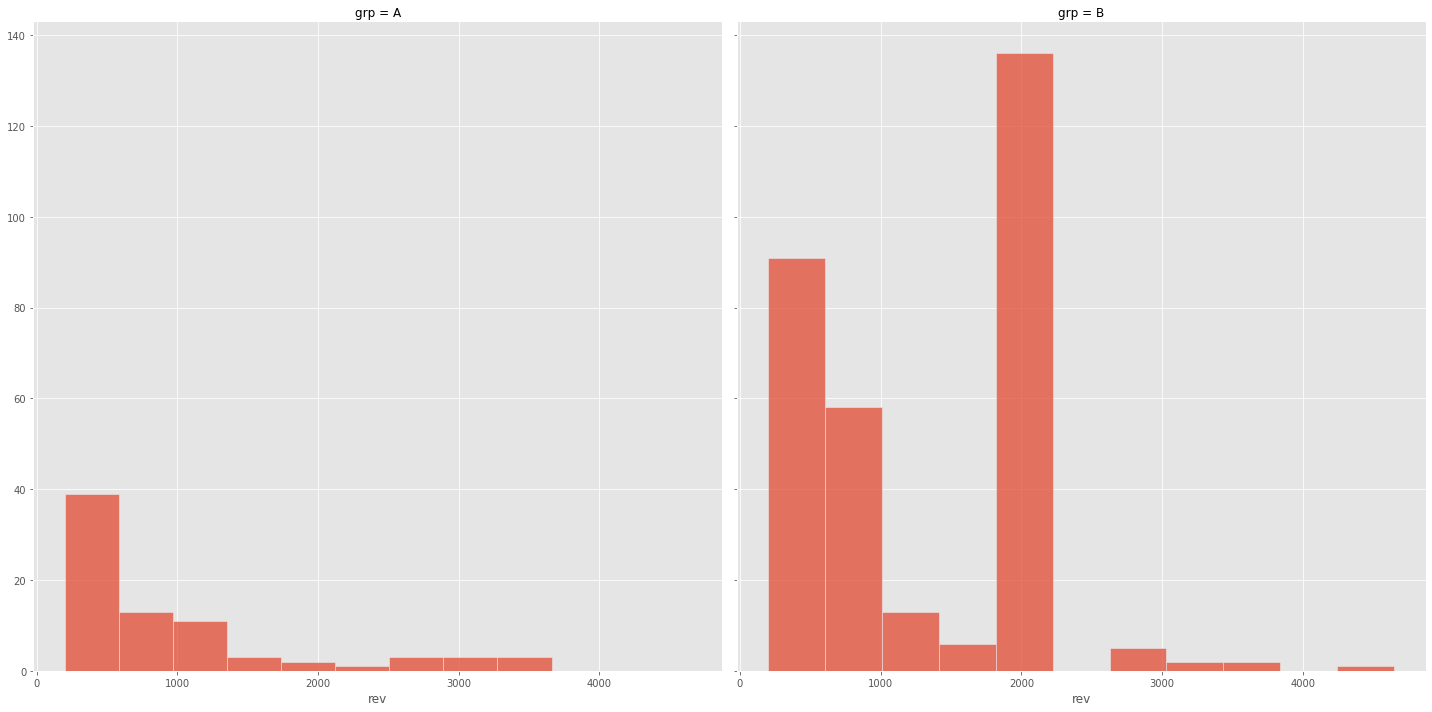

In [13]:
# поищем аномалии покупок
g = sns.FacetGrid(active_purch, col="grp", height=10, aspect=1)
g.map(sns.histplot, "rev")

In [14]:
# Есть явный выброс в Целевой группе (B), а так же распределения ненормальны визуально
## проверим формулами нормальность

In [15]:
a = stats.shapiro(active_purch_a.student_id)
b = stats.shapiro(active_purch_b.student_id)

print('Для контрольной группы P =', a[1])
print('Для целевой группы P =', b[1])

Для контрольной группы P = 0.001170420553535223
Для целевой группы P = 4.307636913836177e-09


In [16]:
# Распределния не нормальны

In [19]:
# также обратим внимание но большой выброс около 2000
active_purch_b.rev.value_counts().head(5)

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
Name: rev, dtype: int64

In [42]:
# обрежем датасет до 1900 (не включительно), что бы убрать фактор акции и проверим его наравне с обычным датасетом
active_1900 = active[active['rev'] < 1900]

In [17]:
# Метрики
## CR - конверсия в покупку
## ARPU - доход на одного пользователя (он же средний чек, тк на одного пользователя одна покупка)
## ARPPU - доход на одного платящего

In [43]:
metrics = active.groupby('grp', as_index=False).agg({'student_id': 'count', 'purch': 'sum', 'rev': 'sum'}) \
                .rename(columns={'student_id': 'num'})
metrics['cr'] = round(metrics['purch'] / metrics['num'] * 100, 2)
metrics['arpu'] = round(metrics['rev'] / metrics['num'], 2)
metrics['arppu'] = round(metrics['rev'] / metrics['purch'], 2)
metrics

,grp,num,purch,rev,cr,arpu,arppu
0,A,1538,78,72820.0000,5.07,47.35,933.59
1,B,6803,314,394974.0035,4.62,58.06,1257.88


In [47]:
# размеры групп сильно отличаются друг от друга, первое что скажем - сплитование точно плохо настроено.

In [45]:
metrics_1900 = active_1900.groupby('grp', as_index=False).agg({'student_id': 'count', 'purch': 'sum', 'rev': 'sum'}) \
                          .rename(columns={'student_id': 'num'})
metrics_1900['cr'] = round(metrics_1900['purch'] / metrics_1900['num'] * 100, 2)
metrics_1900['arpu'] = round(metrics_1900['rev'] / metrics_1900['num'], 2)
metrics_1900['arppu'] = round(metrics_1900['rev'] / metrics_1900['purch'], 2)
metrics_1900

,grp,num,purch,rev,cr,arpu,arppu
0,A,1527,67,40390.0,4.39,26.45,602.84
1,B,6657,168,102379.0,2.52,15.38,609.40


In [48]:
# размеры групп также сильно отличаются друг от друга

In [61]:
# Для датасета с чекам меньше 1900 различия в группах уже другие
## 1 - CR сильно отличается
## 2 - ARPU также значительно просел
## 3 - А вот ARPPU уже, можно сказать, без изменений

In [24]:
# Стат тесты
## Сначала для общего датасета
## Для CR воспольуземся Хи-квадрат, тк покупка это категориальная переменная (купил-некупил)

In [25]:
cros = pd.crosstab(active['grp'], active['purch'])
cros

purch,0,1
grp,,
A,1460,78
B,6489,314


In [26]:
chi2, p, dof, ex = stats.chi2_contingency(cros,correction=False)

round(p, 2)

0.45

In [27]:
# P больше 5, значит принять альтернативную гипотезу не можем - стат. значимых отличий нет

In [28]:
# Для метрик связанных с выручкой нужно брать бутстрап

In [29]:
# задаем функцию

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [36]:
# зададим датафреймы для каждой группы
active_a = active[active['grp'] == 'A']
active_b = active[active['grp'] == 'B']

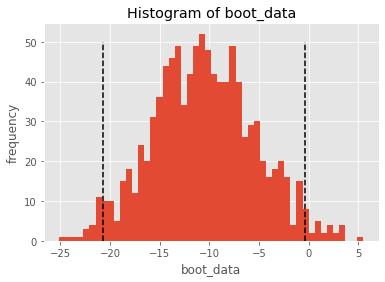

In [30]:
# считаем для среднего дохода

booted_data = get_bootstrap(active_a.rev, active_b.rev, statistic = np.mean)

In [31]:
print('p_value = ', booted_data["p_value"])
print('\n')
print('ci = ', booted_data["ci"])

p_value =  0.04014689327278997


ci =                 0
0.025 -20.715857
0.975  -0.325467


In [59]:
# p_value меньше 5, значит можем отклонить Нулевую гипотезу о равенстве средних чеков

In [38]:
## Теперь посчитаем для датасета с чеками меньше 1900

In [ ]:
## Сначала Хи квадрат

In [39]:
cros_1900 = pd.crosstab(active_1900['grp'], active_1900['purch'])
cros_1900

purch,0,1
grp,,
A,1460,67
B,6489,168


In [40]:
chi2, p, dof, ex = stats.chi2_contingency(cros_1900,correction=False)

round(p, 2)

0.0

In [41]:
# P меньше 5, значит принять альтернативную гипотезу можем - стат. значимые отличия есть

In [52]:
# зададим датафреймы для каждой группы
active_1900_a = active_1900[active_1900['grp'] == 'A']
active_1900_b = active_1900[active_1900['grp'] == 'B']

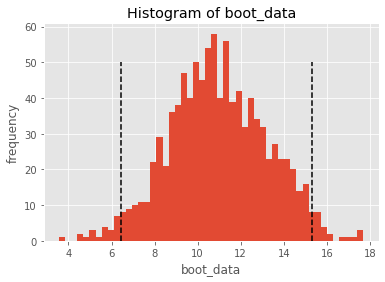

In [53]:
# Бутстрап для среднего дохода

booted_data = get_bootstrap(active_1900_a.rev, active_1900_b.rev, statistic = np.mean)

In [54]:
print('p_value = ', booted_data["p_value"])
print('\n')
print('ci = ', booted_data["ci"])

p_value =  1.2600737597605577e-06


ci =                 0
0.025   6.462701
0.975  15.311495


In [60]:
# p_value меньше 5, значит можем отклонить Нулевую гипотезу о равенстве средних чеков.

In [62]:
metrics

,grp,num,purch,rev,cr,arpu,arppu
0,A,1538,78,72820.0000,5.07,47.35,933.59
1,B,6803,314,394974.0035,4.62,58.06,1257.88


In [63]:
metrics_1900

,grp,num,purch,rev,cr,arpu,arppu
0,A,1527,67,40390.0,4.39,26.45,602.84
1,B,6657,168,102379.0,2.52,15.38,609.40


In [64]:
# выводы
## если принять, что выброс с чеками за 1900 это "фича" - то по стат тестам различия верные
## но такой же выброс может быть изза введенной акции на время проведения теста
### если это все таки акция, то с большой вероятностью показатели в выручке будут хуже, так конверсия в покупателя уменьшилась